# Air-Quality of Abuja: Part 2

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pytz
import seaborn as sns
import plotly.express as px
import glob
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Prepare Data

### Import
The data required for this project is found in CSV files. To import the data, wrangle function is defined. In this function:
* it takes the path of the CSV file as an argument
* read the data from the CSV file to DataFrame
* the data is arranged in a column separated with `;`, hence extract the features needed: **timestamp** and **value**
* set the index to the timestamp
* the given timestamp is not time series, so convert it
* since it is based on UTC timezone, localize it to Africa/Abuja timezone
* drop outliers
* resample the value with 1 hour interval and fill null values with forward-fill method
* since the model is going to be AutoRegressive, return a series

In [2]:
def wrangle(file_path):
    # Read CSV file
    df = pd.read_csv(file_path)
    
    # Select only rows with P2 values
    df = df[df["sensor_id;sensor_type;location;lat;lon;timestamp;value_type;value"].str.contains("P2")]
    
    # Extract features
    df[["timestamp", "value"]] = df[df.columns[0]].str.split(";", expand= True)[[5, 7]]
    
    # Drop old column
    df.drop(columns= df.columns[0], inplace= True)
    
    # Set index to timestamp, cast data type of value
    df = df.set_index("timestamp")
    df["value"] = df["value"].astype("float")
    
    # convert the index to time series
    df.index = pd.to_datetime(df.index, format='ISO8601')
    
    # Localize to Africa/Nairobi timezone
    df.index = df.index.tz_convert("Africa/Lagos")
    df = df.sort_index()
    # Drop outliers, i.e., values > 500
    df["value"] = df[df["value"] < 150]
    
    # Resample with 1 hour period and fill null values with forward-fill
    y = df["value"].resample("1h").mean().ffill()
    
    return y

In this project, Pm2.5 measurements from November 2022 to February 2024 are used to develop a Linear Regression model.

The CSV files are imported and concatenated fo form a DataFrame.

In [3]:
files = glob.glob("*_sensor_data_archive.csv")
print(files)

['april_2023_sensor_data_archive.csv', 'august_2023_sensor_data_archive.csv', 'december_2022_sensor_data_archive.csv', 'december_2023_sensor_data_archive.csv', 'february_2023_sensor_data_archive.csv', 'february_2024_sensor_data_archive.csv', 'january_2023_sensor_data_archive.csv', 'january_2024_sensor_data_archive.csv', 'july_2023_sensor_data_archive.csv', 'june_2023_sensor_data_archive.csv', 'march_2023_sensor_data_archive.csv', 'may_2023_sensor_data_archive.csv', 'november_2022_sensor_data_archive.csv', 'november_2023_sensor_data_archive.csv', 'october_2023_sensor_data_archive.csv', 'september_2023_sensor_data_archive.csv']


In [4]:
frames = [wrangle(file) for file in files]

In [5]:
y = pd.concat(frames).sort_index()
y.info()
y.head(20)

<class 'pandas.core.series.Series'>
DatetimeIndex: 11023 entries, 2022-11-07 13:00:00+01:00 to 2024-03-01 00:00:00+01:00
Series name: value
Non-Null Count  Dtype  
--------------  -----  
11023 non-null  float64
dtypes: float64(1)
memory usage: 172.2 KB


timestamp
2022-11-07 13:00:00+01:00    14.119014
2022-11-07 14:00:00+01:00     4.350000
2022-11-07 15:00:00+01:00     4.350000
2022-11-07 16:00:00+01:00    18.834722
2022-11-07 17:00:00+01:00    18.834722
2022-11-07 18:00:00+01:00    18.834722
2022-11-07 19:00:00+01:00    18.834722
2022-11-07 20:00:00+01:00    18.834722
2022-11-07 21:00:00+01:00    18.834722
2022-11-07 22:00:00+01:00    18.834722
2022-11-07 23:00:00+01:00    18.834722
2022-11-08 00:00:00+01:00    18.834722
2022-11-08 01:00:00+01:00    18.834722
2022-11-08 02:00:00+01:00    18.834722
2022-11-08 03:00:00+01:00    18.834722
2022-11-08 04:00:00+01:00    18.834722
2022-11-08 05:00:00+01:00    18.834722
2022-11-08 06:00:00+01:00    18.834722
2022-11-08 07:00:00+01:00    18.834722
2022-11-08 08:00:00+01:00    54.970833
Name: value, dtype: float64

### Explore

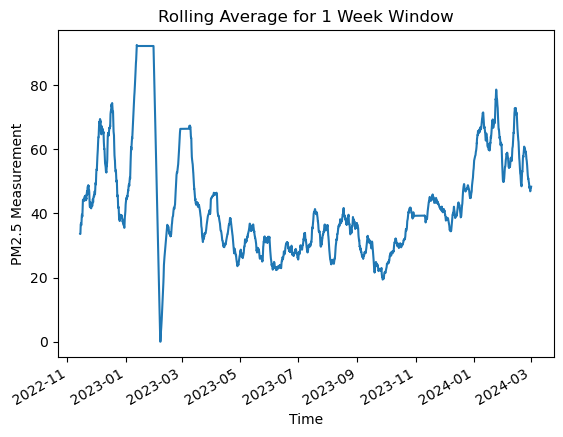

In [6]:
y.rolling(168).mean().dropna().plot()
plt.xlabel("Time")
plt.ylabel("PM2.5 Measurement")
plt.title("Rolling Average for 1 Week Window");

Autocorrelation function (ACF) plot: This graph shows how correlation coefficients change over time.

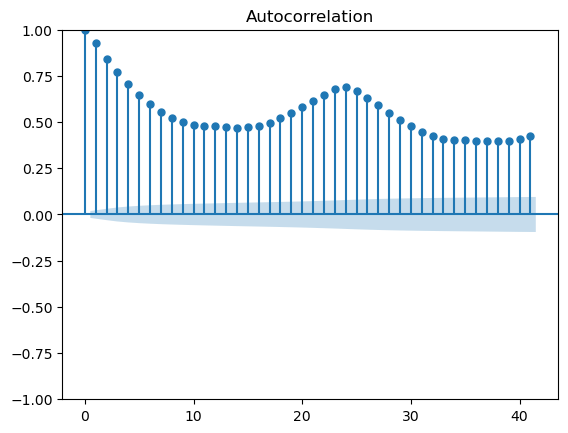

In [7]:
plot_acf(y);

Partial autocorrelation function (PACF) plot: This plot returns a graph showing there is a slight relationship between lag values with the current time.

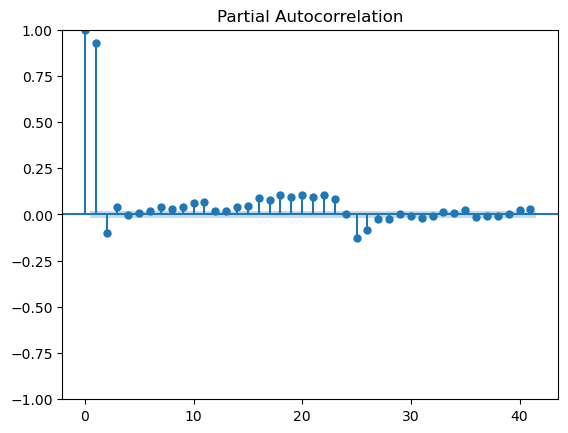

In [8]:
plot_pacf(y);

### Split
Use 5% of the data for test sets.

In [9]:
cutoff = int(len(y) * 0.95)
y_train = y.iloc[:cutoff]
y_test = y.iloc[cutoff:]

In [10]:
assert y_train.shape == (10471, ), f"Shape of X_train should be (450, ) not {y_train.shape}"
assert y_test.shape == (552, ), f"Shape of X_test should be (113, ) not {y_test.shape}"

## Build Model
### Baseline

In [11]:
y_pred_baseline = [y_train.mean()] * len(y_train)
MAE_baseline = mean_absolute_error(y_train, y_pred_baseline)
print(f"Baseline value: {round(y_train.mean(), 3)}")
print(f"Baseline MAE: {MAE_baseline.round(3)}")

Baseline value: 42.016
Baseline MAE: 18.4


In [12]:
y_train.iloc[150:200]

timestamp
2022-11-13 19:00:00+01:00     36.280556
2022-11-13 20:00:00+01:00     49.424545
2022-11-13 21:00:00+01:00     63.706329
2022-11-13 22:00:00+01:00    110.714045
2022-11-13 23:00:00+01:00     74.503604
2022-11-14 00:00:00+01:00     27.334513
2022-11-14 01:00:00+01:00     14.664865
2022-11-14 02:00:00+01:00     13.659821
2022-11-14 03:00:00+01:00     18.750917
2022-11-14 04:00:00+01:00     14.958182
2022-11-14 05:00:00+01:00     16.429464
2022-11-14 06:00:00+01:00     19.445946
2022-11-14 07:00:00+01:00     26.343056
2022-11-14 08:00:00+01:00     16.751376
2022-11-14 09:00:00+01:00     10.113861
2022-11-14 10:00:00+01:00     13.462617
2022-11-14 11:00:00+01:00     12.824074
2022-11-14 12:00:00+01:00     13.291837
2022-11-14 13:00:00+01:00     11.828922
2022-11-14 14:00:00+01:00     11.229703
2022-11-14 15:00:00+01:00     13.662366
2022-11-14 16:00:00+01:00     17.863063
2022-11-14 17:00:00+01:00     21.598544
2022-11-14 18:00:00+01:00     85.310000
2022-11-14 19:00:00+01:00    1

### Iterate

In [14]:
model = AutoReg(y_train, lags= 25).fit()

C:\Users\IYUEL\anaconda3\envs\main\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [15]:
model

### Evaluate

In [16]:
AutoReg?

Init signature:
AutoReg(
    endog: 'ArrayLike1D',
    lags: 'int | Sequence[int] | None',
    trend: "Literal['n', 'c', 't', 'ct']" = 'c',
    seasonal: 'bool' = False,
    exog: 'ArrayLike2D | None' = None,
    hold_back: 'int | None' = None,
    period: 'int | None' = None,
    missing: 'str' = 'none',
    *,
    deterministic: 'DeterministicProcess | None' = None,
    old_names: 'bool' = False,
)
Docstring:     
Autoregressive AR-X(p) model

Estimate an AR-X model using Conditional Maximum Likelihood (OLS).

Parameters
----------
endog : array_like
    A 1-d endogenous response variable. The dependent variable.
lags : {None, int, list[int]}
    The number of lags to include in the model if an integer or the
    list of lag indices to include.  For example, [1, 4] will only
    include lags 1 and 4 while lags=4 will include lags 1, 2, 3, and 4.
    None excludes all AR lags, and behave identically to 0.
trend : {'n', 'c', 't', 'ct'}
    The trend to include in the model:

    * 'n' 

In [17]:
print(model.aic, model.hqic, model.bic)

75309.88388708237 75376.03675583679 75505.74119612527


In [18]:
y_train.index[0]

Timestamp('2022-11-07 13:00:00+0100', tz='Africa/Lagos')

In [19]:
y_pred = model.predict(start= y_train.index[0], end= y_train.index[len(y_train) - 1], dynamic= False)
y_pred
# train_mae = mean_absolute_error(y_train, model.predict(X_train))
# test_mae = mean_absolute_error(y_test, model.predict(X_test))
# print("Train MAE: ", train_mae.round(3))
# print("Test MAE: ", test_mae.round(3))

timestamp
2022-11-07 13:00:00+01:00   NaN
2022-11-07 14:00:00+01:00   NaN
2022-11-07 15:00:00+01:00   NaN
2022-11-07 16:00:00+01:00   NaN
2022-11-07 17:00:00+01:00   NaN
                             ..
2024-02-06 20:00:00+01:00   NaN
2024-02-06 21:00:00+01:00   NaN
2024-02-06 22:00:00+01:00   NaN
2024-02-06 23:00:00+01:00   NaN
2024-02-07 00:00:00+01:00   NaN
Length: 10471, dtype: float64

Hence, the model preforms better than the baseline and canbe used to predict future PM2.5 levels.

## Communicate Results

The equation for the Linear Regression model can be given as below:

>***P2 = intercept + coefficient * P2.L1***

In [20]:
intercept = model..round(3)
coefficients = model.coef_.round(3)
print(f"P2 = {intercept} + {coefficients[0]} * P2.L1")

AttributeError: 'AutoRegResults' object has no attribute 'intercept_'

Let' create a DataFrame containing the testing target series and the prediction of the model on the testing features matrix.

In [21]:
df_pred_test = pd.DataFrame({"y_test": y_test, "y_pred": model.predict(X_test)}, index= y_test.index)
df_pred_test.head()

NameError: name 'X_test' is not defined

Now plot the above DataFrame to see the relationship between the true test data and predicted one.

In [ ]:
fig = px.line(df_pred_test, labels= {"value": "P2"})
fig.show()